<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220805.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [2]:
import pandas as pd 
import numpy as np 
import plotnine as gg 
from plotnine import ggplot, aes 

from datetime import datetime, date, time, timezone, timedelta
import os 
import re 

from functools import reduce 
from collections import ChainMap, defaultdict, Counter

# customer analysis

In [18]:
df = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name = 'Transactions')
df.head()

,Note: The data and information in this document is reflective of a hypothetical situation and client. This document is to be used for KPMG Virtual Internship purposes only.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145


In [19]:
df.columns = df.iloc[0]
df.drop([0], axis = 0, inplace = True)
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145
5,5,78,787,2017-10-01 00:00:00,True,Approved,Giant Bicycles,Standard,medium,large,1765.3,709.48,42226


In [20]:
df = df[df.order_status == 'Approved']

In [21]:
df['date'] = df.transaction_date.to_numpy().astype('datetime64[D]')
df['month'] = df['date'].to_numpy().astype('datetime64[M]')
df = df[['customer_id', 'date', 'month', 'standard_cost', 'brand']].rename(columns = {'customer_id':'id', 'standard_cost': 'rev'})
df.head()

,id,date,month,rev,brand
1,2950,2017-02-25,2017-02-01,53.62,Solex
2,3120,2017-05-21,2017-05-01,388.92,Trek Bicycles
3,402,2017-10-16,2017-10-01,248.82,OHM Cycles
4,3135,2017-08-31,2017-08-01,381.1,Norco Bicycles
5,787,2017-10-01,2017-10-01,709.48,Giant Bicycles


In [22]:
df = df.groupby(['id', 'date', 'month', 'brand'])['rev'].sum().reset_index()

In [23]:
list_pu = df.groupby(['id', 'month', 'brand'])['rev'].sum().reset_index().sort_values(['id', 'month', 'brand'], ascending = [1,1,1])
list_npu = list_pu.groupby(['id', 'brand']).first().reset_index()
list_mon = list_npu['month'].sort_values().unique()
list_brand = list_npu['brand'].unique()

In [24]:
cnt = 0

for brand in list_brand : 
  for mon in list_mon : 
      temp_npu = list_npu[(list_npu['month'] == mon) & (list_npu['brand'] == brand)]
      temp_pu = list_pu[(list_pu['id'].isin(temp_npu['id'])) & (list_pu['brand'] == brand)]
      temp = temp_pu.groupby(['month', 'brand'])['id'].count().reset_index().rename(columns = {'id':'pu'})
      temp = temp.assign(npu_month = str(mon)[:10], 
                         num = temp['month'].rank(),
                         ratio = lambda x : round(x['pu']/x['pu'].max()*100,2))
      temp = temp[['brand','npu_month', 'num', 'pu', 'ratio']]

      if cnt == 0 :
        res = temp
      else :
        res = pd.concat([res, temp], axis = 0)
      cnt += 1

res = pd.melt(res, id_vars = ['brand', 'npu_month', 'num'], var_name = 'type')
res.head()

,brand,npu_month,num,type,value
0,Giant Bicycles,2017-01-01,1.0,pu,271.0
1,Giant Bicycles,2017-01-01,2.0,pu,24.0
2,Giant Bicycles,2017-01-01,3.0,pu,12.0
3,Giant Bicycles,2017-01-01,4.0,pu,21.0
4,Giant Bicycles,2017-01-01,5.0,pu,21.0


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


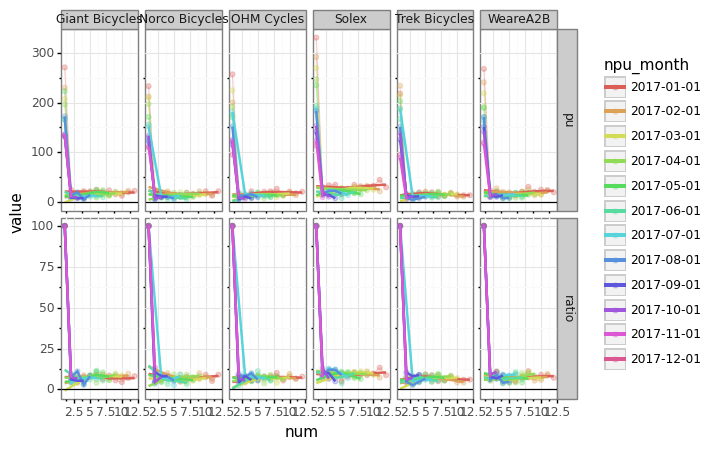

<ggplot: (8783057506209)>

In [28]:
(
    ggplot(res, aes('num','value', color = 'npu_month')) +
    gg.geom_line(alpha = .3) +
    gg.geom_point(alpha = .3) +
    gg.geom_smooth(se = False) + 
    gg.geom_hline(yintercept = 0) +
    gg.facet_grid('type~brand', scales = 'free_y') +
    gg.theme_bw()
)

In [37]:
info_m = df.groupby(['id','month','brand'])['rev'].sum().reset_index().rename(columns = {'rev':'money'})
info_m = pd.pivot_table(info_m, index = ['id','brand'], columns = 'month', values = 'money').reset_index()
info_m = pd.melt(info_m, id_vars = ['id', 'brand'], var_name = 'month', value_name = 'money').sort_values(['id','brand','month'], ascending = [1,1,0])
info_m = info_m.groupby(['id', 'brand']).head(3)
info_m = info_m.groupby(['id', 'brand'])['money'].sum().reset_index()
info_m.head()

,id,brand,money
0,1,Giant Bicycles,173.18
1,1,Norco Bicycles,0.00
2,1,OHM Cycles,792.47
3,1,Solex,0.00
4,1,Trek Bicycles,0.00


In [38]:
info_f = df.groupby(['id','month','brand'])['rev'].count().reset_index().rename(columns = {'rev':'freq'})
info_f = pd.pivot_table(info_f, index = ['id','brand'], columns = 'month', values = 'freq').reset_index()
info_f = pd.melt(info_f, id_vars = ['id', 'brand'], var_name = 'month', value_name = 'freq').sort_values(['id','brand','month'], ascending = [1,1,0])
info_f = info_f.groupby(['id', 'brand']).head(3)
info_f = info_f.groupby(['id', 'brand'])['freq'].sum().reset_index()
info_f.head()

,id,brand,freq
0,1,Giant Bicycles,1.0
1,1,Norco Bicycles,0.0
2,1,OHM Cycles,2.0
3,1,Solex,0.0
4,1,Trek Bicycles,0.0


In [39]:
date_max = (df['date'] + pd.offsets.MonthEnd(0)).max()
date_max

Timestamp('2017-12-31 00:00:00')

In [40]:
info_r = df.groupby(['id', 'brand']).agg({'date': lambda x : (date_max - x.max()).days}).reset_index().rename(columns = {'date':'recency'})
info_r.head()

,id,brand,recency
0,1,Giant Bicycles,17
1,1,Norco Bicycles,279
2,1,OHM Cycles,8
3,1,Solex,269
4,1,Trek Bicycles,234


In [42]:
info = pd.merge(pd.merge(info_r, info_f, 'left', ['id', 'brand']), info_m, 'left', ['id', 'brand'])
info.head()

,id,brand,recency,freq,money
0,1,Giant Bicycles,17,1.0,173.18
1,1,Norco Bicycles,279,0.0,0.00
2,1,OHM Cycles,8,2.0,792.47
3,1,Solex,269,0.0,0.00
4,1,Trek Bicycles,234,0.0,0.00


# iterator

In [43]:
import enum
mat = [list('ABC'), list('DEF'), list('HGI')]
for r, rows in enumerate(mat) :
  for c, letters in enumerate(rows) : 
    print(f'({r}, {c})-{letters}')

(0, 0)-A
(0, 1)-B
(0, 2)-C
(1, 0)-D
(1, 1)-E
(1, 2)-F
(2, 0)-H
(2, 1)-G
(2, 2)-I


In [44]:
portfolio = [
    ('GOOG', 100, 490.1),
    ('IBM', 50, 91.1),
    ('CAT', 150, 83.44),
    ('IBM', 100, 45.23),
    ('GOOG', 75, 572.45),
    ('AA', 50, 23.15)
]
portfolio

[('GOOG', 100, 490.1),
 ('IBM', 50, 91.1),
 ('CAT', 150, 83.44),
 ('IBM', 100, 45.23),
 ('GOOG', 75, 572.45),
 ('AA', 50, 23.15)]

In [45]:
a, b, c, d = Counter(), defaultdict(int), defaultdict(int), defaultdict(list)

for com, share, price in portfolio : 
  a[com] += 1
  b[com] += 1
  c[com] += share
  d[com].append((share, price))

print(a)
print(b)
print(c)
print(d)

Counter({'GOOG': 2, 'IBM': 2, 'CAT': 1, 'AA': 1})
defaultdict(<class 'int'>, {'GOOG': 2, 'IBM': 2, 'CAT': 1, 'AA': 1})
defaultdict(<class 'int'>, {'GOOG': 175, 'IBM': 150, 'CAT': 150, 'AA': 50})
defaultdict(<class 'list'>, {'GOOG': [(100, 490.1), (75, 572.45)], 'IBM': [(50, 91.1), (100, 45.23)], 'CAT': [(150, 83.44)], 'AA': [(50, 23.15)]})


In [46]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'age': 73,
  'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M'},
 {'age': 29,
  'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F'},
 {'age': 51,
  'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M'},
 {'age': 32,
  'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F'},
 {'age': 42, 'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F'}]

In [47]:
for key in list(users[0].keys()) :

  if key == list(users[0].keys())[0] :

    res = eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]],users,[])')

  else : 

    res = np.c_[res, eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]],users,[])')]

res

array([['gregorythomas@gmail.com', 'Brett Holland', 'M', '73'],
       ['hintoncynthia@hotmail.com', 'Madison Martinez', 'F', '29'],
       ['wwagner@gmail.com', 'Michael Jenkins', 'M', '51'],
       ['daniel79@gmail.com', 'Karen Rodriguez', 'F', '32'],
       ['ujackson@gmail.com', 'Amber Rhodes', 'F', '42']], dtype='<U25')

In [48]:
{key : eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]],users,[])') for key in list(users[0].keys())}

{'age': [73, 29, 51, 32, 42],
 'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F']}